# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2
import random
import pickle
import os

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from moviepy.editor import VideoFileClip

%matplotlib inline  

# Load images

In [34]:
folder_names = ['C:/Users/chaym/Downloads/OwnCollection/vehicles/Far', 
            'C:/Users/chaym/Downloads/OwnCollection/vehicles/Left', 
            'C:/Users/chaym/Downloads/OwnCollection/vehicles/MiddleClose',
            'C:/Users/chaym/Downloads/OwnCollection/vehicles/Right']

car_set = []
for folder_name in folder_names:
    for file in os.listdir(folder_name):
        img = cv2.imread(folder_name + '/' + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        car_set.append(img)

folder_names = ['C:/Users/chaym/Downloads/OwnCollection/non-vehicles/Far', 
        'C:/Users/chaym/Downloads/OwnCollection/non-vehicles/Left', 
        'C:/Users/chaym/Downloads/OwnCollection/non-vehicles/MiddleClose',
        'C:/Users/chaym/Downloads/OwnCollection/non-vehicles/Right']

no_car_set = []
for folder_name in folder_names:
    for file in os.listdir(folder_name):
        img = cv2.imread(folder_name + '/' + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        no_car_set.append(img)

In [35]:
data = car_set + no_car_set
label = [True]*len(car_set) + [False]*len(no_car_set)
num_data = len(data)

idxes = list(range(num_data))
random.shuffle(idxes)

x = np.ndarray((num_data, 64, 64, 3))
y = [None]*num_data

counter = 0
for idx in idxes:
    x[counter,:,:,:] = data[idx]/255
    y[counter] = label[idx]
    counter += 1

# HOG and SVM

In [36]:
# Feature vector helper functions
def getHogFeature(img, stackFeatureVector = False):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                      visualize=True, feature_vector=stackFeatureVector)
    return features

Extract feature vectors and normalize

In [37]:
# Length of feature vector is 5292
x_hog = np.ndarray((num_data, 5292))
for i in range(num_data):
    hogFeatures = np.hstack((getHogFeature(x[i,:,:,0], True), getHogFeature(x[i,:,:,1], True), getHogFeature(x[i,:,:,2], True)))
    x_hog[i, :] = hogFeatures

# Fit standard scaler and apply to the data
x_hog_scaler = StandardScaler().fit(x_hog)
x_hog = x_hog_scaler.transform(x_hog)

Train linear SVM

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_hog, y, test_size=0.02)
svm_model = LinearSVC()
svm_model.fit(x_train, y_train)
              
print('training acc:', svm_model.score(x_train, y_train))
print('testing acc:', svm_model.score(x_test, y_test))

training acc: 1.0
testing acc: 0.9727891156462585


# CNN

In [39]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=0.2)

datagen.fit(x)

train_data = datagen.flow(x, y, batch_size=32, subset='training')
validation_data = datagen.flow(x, y, batch_size=32, subset='validation')

In [40]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv2D(16, kernel_size=(5,5), input_shape=(64, 64, 3), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
cnn_model.add(keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=1,activation='sigmoid'))
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 16)        6416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               692480    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [41]:
history = cnn_model.fit_generator(train_data, epochs=4, validation_data=validation_data)

Epoch 1/4
184/184 [==============================] - 67s 293ms/step - loss: 0.4839 - accuracy: 0.7931 - val_loss: 0.1433 - val_accuracy: 0.9488
Epoch 2/4
184/184 [==============================] - 25s 135ms/step - loss: 0.1248 - accuracy: 0.9552 - val_loss: 0.0725 - val_accuracy: 0.9727
Epoch 3/4
184/184 [==============================] - 24s 133ms/step - loss: 0.0997 - accuracy: 0.9641 - val_loss: 0.1054 - val_accuracy: 0.9672
Epoch 4/4
184/184 [==============================] - 25s 133ms/step - loss: 0.0957 - accuracy: 0.9660 - val_loss: 0.0750 - val_accuracy: 0.9700


In [33]:
scores = cnn_model.evaluate(validation_data, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.25%


# Test SVM and CNN models 

In [127]:
def findCarSvmForScale(img, ystart, ystop, scale, svm_model, x_scaler):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    # Only search x > 500 
    xstart = 500
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = getHogFeature(ch1)
    hog2 = getHogFeature(ch2)
    hog3 = getHogFeature(ch3)
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = x_scaler.transform(hog_features).reshape(1, -1)

            test_prediction = svm_model.predict(test_features)
            
            if test_prediction[0] == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append((xbox_left+xstart, ytop_draw+ystart, win_draw))
                              
    return rectangles

def findCarCnnForWin(img, model, datagen, win_size, step_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    h, w, _ = img.shape
    xRange = range(500, w-win_size, step_size)
    yRange = range(400, 500, step_size)
    numWindow = len(xRange)*len(yRange)
    windows = np.ndarray((numWindow, 64, 64, 3))
    xcor = np.ndarray((numWindow, 1))
    ycor = np.ndarray((numWindow, 1))
    counter = 0
    for y in yRange:
        for x in xRange:
            window = img[y:y+win_size, x:x+win_size, :]
            window = cv2.resize(window, (64,64))
            window = window/255
            datagen.standardize(window)
            windows[counter] = window
            xcor[counter] = x
            ycor[counter] = y
            counter += 1
    
    predictP = model.predict(windows)
    rects = [(int(xcor[i]), int(ycor[i]), win_size) for i in range(len(xcor)) if predictP[i] > 0.5]
    return rects

def getHeatMap(img, method, svm_model, x_scaler, cnn_model, datagen, visualize):
    if method == 'svm':
        scales = [1, 1.5, 2, 2.5]
        y_ranges = [(400, 530),(400, 620), (400, 650), (400, 700)]
        num_scale_or_win = len(scales)
    elif method == 'cnn':
        win_sizes = [32, 64, 80, 96, 128]
        step_sizes = [4, 8, 10, 12, 16]
        num_scale_or_win = len(win_sizes)
    else:
        return []
    
    h, w, _ = img.shape
    heat_map = np.zeros((h,w))
    
    if visualize:
        # show original image
        rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(rgbImg)
        # image for car boxes
        plt.figure()
        plt.imshow(rgbImg)
        ax = plt.gca()
        colors = ['r','g','b','y','c','m','k']
    
    for i in range(num_scale_or_win):
        if method == 'svm':
            # Find cars for specific scale
            scale = scales[i]
            y_range = y_ranges[i]
            rects = findCarSvmForScale(img, y_range[0], y_range[1], scale, svm_model, x_scaler)
        if method == 'cnn':
            # Find cars for specific window size
            win_size = win_sizes[i]
            step_size = step_sizes[i]
            rects = findCarCnnForWin(img, cnn_model, datagen, win_size, step_size)

        for rect in rects:
            x, y, w = rect
            heat_map[y:y+w,x:x+w] += 1
            if visualize:
                # image for car boxes
                re = Rectangle((x,y),w,w,linewidth=2,edgecolor=colors[i],facecolor='none')
                ax.add_patch(re)

    return heat_map

def getBoundingBoxes(heat_map, heat_map_threshold, visualize):
    filtered_heat_map = heat_map > heat_map_threshold
    filtered_heat_map = filtered_heat_map.astype(np.uint8)
    
    if visualize:
        # image for heat map and filtered heat map
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(heat_map)
        plt.subplot(1,2,2)
        plt.imshow(filtered_heat_map)

    ccResult = cv2.connectedComponentsWithStats(filtered_heat_map)
    ccStats = ccResult[2]
    
    finalRects = []
    for ccBox in ccStats:
        numPixel = ccBox[4]
        if (numPixel > 20*20) and (numPixel < 500*500):
            finalRects.append(ccBox)

    return finalRects
            
def findCar(img, method, svm_model, x_scaler, cnn_model, datagen, visualize):
    if method == 'svm':
        heat_map_threshold = 10
    elif method == 'cnn':
        heat_map_threshold = 50
    else:
        return []
    
    heat_map = getHeatMap(img, method, svm_model, x_scaler, cnn_model, datagen, visualize)
    finalRects = getBoundingBoxes(heat_map, heat_map_threshold, visualize)

    if visualize:
        rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(rgbImg)
        ax = plt.gca()
        for rect in finalRects:
            x, y, w, h, _ = rect
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor='y',facecolor='none')
            ax.add_patch(rect)
        plt.axis('off')
                    
    return finalRects

## SVM results

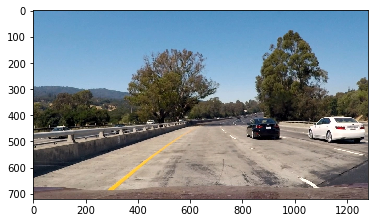

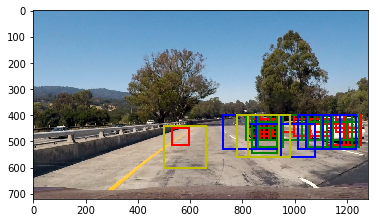

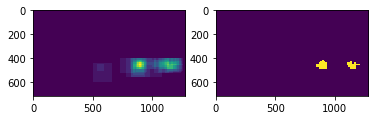

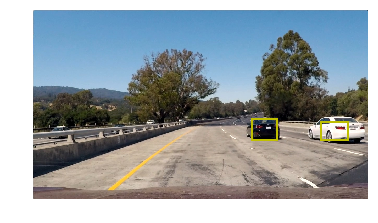

In [128]:
rects = findCar(cv2.imread('test1.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

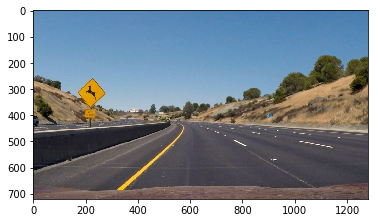

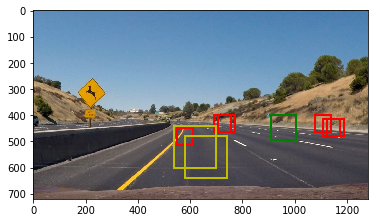

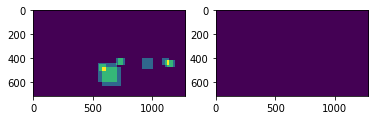

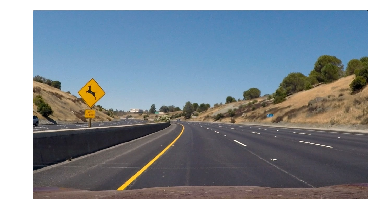

In [129]:
rects = findCar(cv2.imread('test2.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

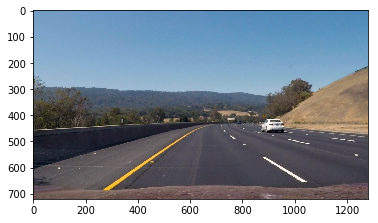

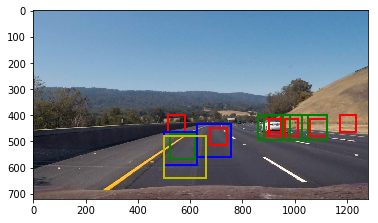

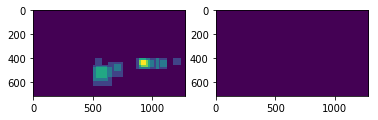

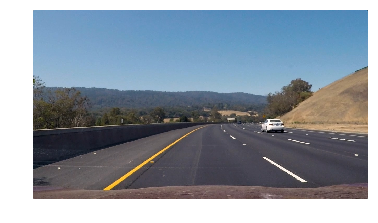

In [130]:
rects = findCar(cv2.imread('test3.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

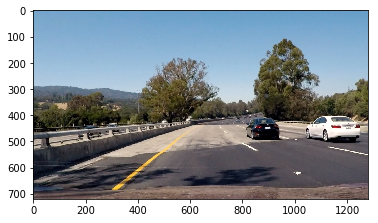

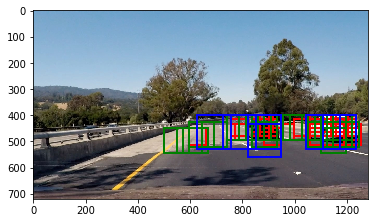

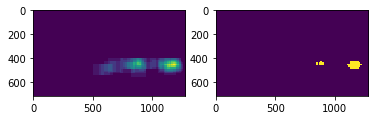

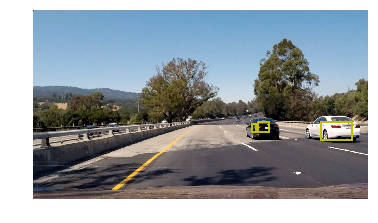

In [131]:
rects = findCar(cv2.imread('test4.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

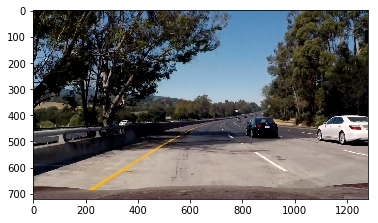

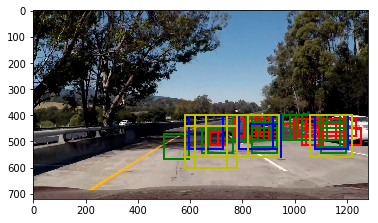

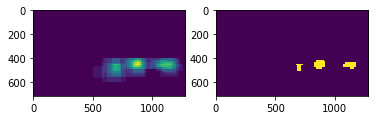

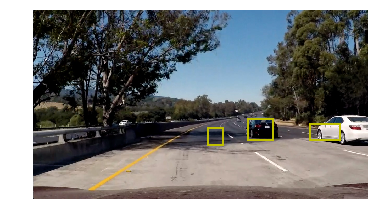

In [132]:
rects = findCar(cv2.imread('test5.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

## CNN results

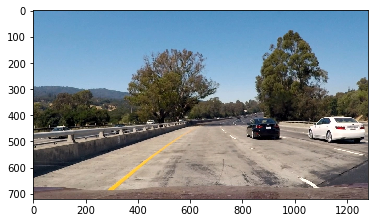

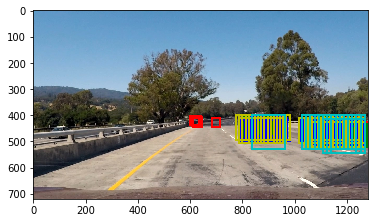

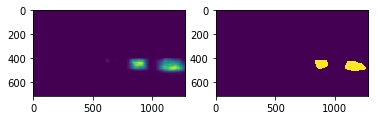

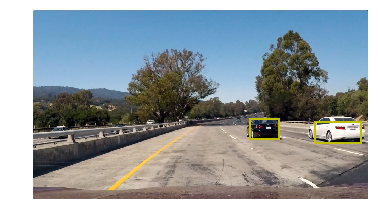

In [133]:
rects = findCar(cv2.imread('test1.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

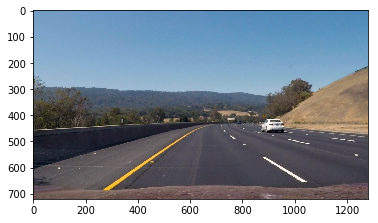

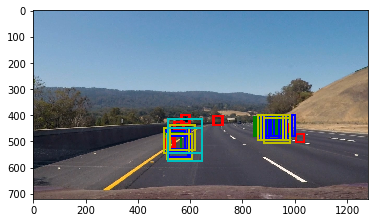

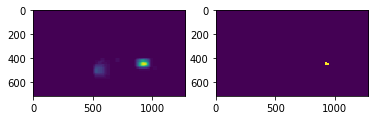

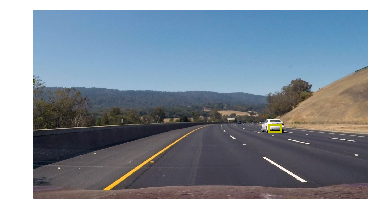

In [135]:
rects = findCar(cv2.imread('test3.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)